# Spatial Autocorrelation
- ## Moran's I
- ## Geary's C
- ## Variogram

In [12]:
library('dplyr')
library('spdep')
library('geoR')
options(repr.plot.width=5, repr.plot.height=5)
# Load data and metadata
# ---------------------------------
setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Final Project/'))
date_str <- '20170112'
data_file <- paste0('gauge_data/','gauge_data_daily.csv')
data_cols <- c('station_id','date_time','quality',
                 'obs_precip', 'precip_ind','snow','eor')

gauge_data <- read.csv(data_file, col.names=data_cols)

In [13]:
meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_metadata <- read.csv('gauge_data/gauge_metadata.csv', col.names=meta_cols)
# Get one day (or hour), and attach metadata
gauge_data_filtered <- filter(gauge_data, date_time==date_str)
gauges <- merge(gauge_data_filtered, gauge_metadata, by='station_id', all.y=TRUE)
# Make sure to clean out NA or < 0 (unknown values)
gauges <- na.omit(gauges)
gauges <- filter(gauges, obs_precip>=0)

### Create weights matrix (inverse distances)

In [14]:
# Weights matrix
distances <- as.matrix(dist(gauges))
inv_dist = 1/distances
diag(inv_dist) <- 0
print(inv_dist[1:5,1:5])
# Create list of weights from matrix, required by moran.test function
wts <- mat2listw(inv_dist)

Warning message in dist(gauges):
“NAs introduced by coercion”

             1            2            3            4            5
1 0.000000e+00 8.953541e-05 0.0000844108 9.233253e-05 9.232112e-05
2 8.953541e-05 0.000000e+00 0.0014478351 2.935130e-03 2.713655e-03
3 8.441080e-05 1.447835e-03 0.0000000000 9.751774e-04 9.847633e-04
4 9.233253e-05 2.935130e-03 0.0009751774 0.000000e+00 6.710661e-03
5 9.232112e-05 2.713655e-03 0.0009847633 6.710661e-03 0.000000e+00


## Run Moran's I and Geary's C 

In [15]:
# Prepare SPDF
xy_coords <- cbind(gauges$longitude, gauges$latitude) 
proj_wgs84 = CRS("+init=epsg:4326")
coordinates(gauges) <- xy_coords
proj4string(gauges) <- proj_wgs84

# Moran's I
I <- moran.test(gauges$obs_precip, wts)
print(I)


	Moran I test under randomisation

data:  gauges$obs_precip  
weights: wts  

Moran I statistic standard deviate = 2.2478, p-value = 0.01229
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.048122478      -0.006172840       0.000583463 



## Results

** I statistic deviation ~= 2.25 > 1.96  **

** H0 can be rejected at 5% confidence level **

** Gauge distribution has positive autocorrelation **

## Visualization of Moran's I result
** Using Monte Carlo distribution of synthetic Moran's I **

In [16]:
I_mc <- moran.mc(gauges$obs_precip, wts, nsim=9999)
# Get value of 1.96 Stdev of the Monte Carlo distribution
sd2 <- 1.96 * sd(I_mc$res)

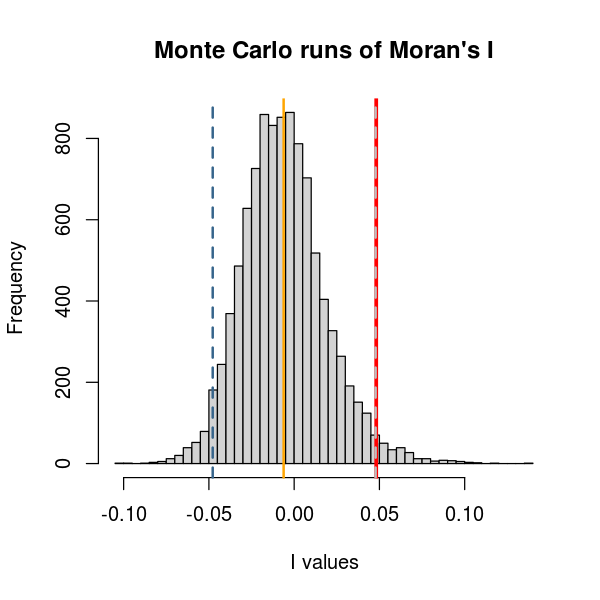

In [17]:
hist(I_mc$res, xlab="I values", 
     main="Monte Carlo runs of Moran's I", 
     breaks=50, col="lightgrey")
abline(v=I$estimate[1], col="red", lwd=3)
abline(v=I$estimate[2], col="orange", lwd=2)
abline(v=sd2, col="grey", lwd=2, lty="dashed")
abline(v=-sd2, col="steelblue4", lwd=2, lty="dashed")

In [18]:
# Geary's C
geary.test(gauges$obs_precip, wts)


	Geary C test under randomisation

data:  gauges$obs_precip 
weights: wts 

Geary C statistic standard deviate = 0.23014, p-value = 0.409
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.979789755       1.000000000       0.007711872 


## Variogram and Envelope

In [19]:
# Variogram and Envelope
coord_matrix <- cbind(gauges$longitude, gauges$latitude)
vg <- variog(coords=coord_matrix, 
             data=gauges$obs_precip)
# Run 9999 Monte Carlo simulations
vg_envel <- variog.mc.env(coords=coord_matrix, 
                          data=gauges$obs_precip, 
                          obj.var=vg, 
                          nsim=9999)

variog: computing omnidirectional variogram
variog.env: generating 9999 simulations by permutating data values
variog.env: computing the empirical variogram for the 9999 simulations
variog.env: computing the envelops


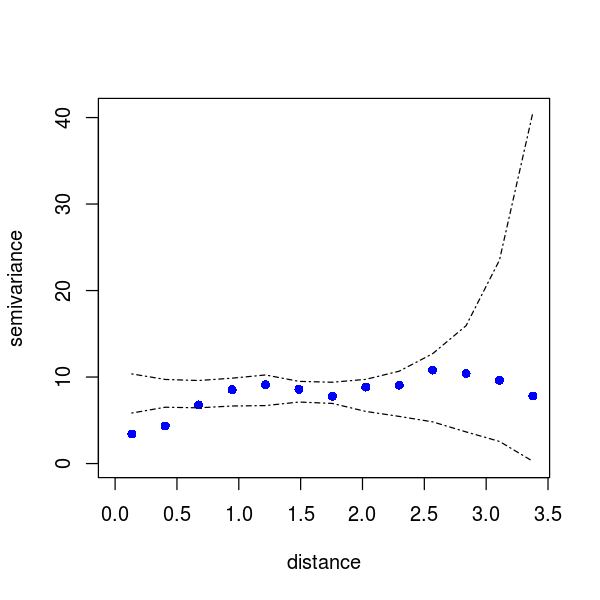

In [20]:
options(repr.plot.width=5, repr.plot.height=5)
plot(vg, envelope=vg_envel, pch=16, col="blue")

## Limit Maximum Distance of Variogram

In [21]:
vg <- variog(coords=coord_matrix, 
             data=gauges$obs_precip, max.dist=1.5)
# Run 999 Monte Carlo simulations
vg_envel <- variog.mc.env(coords=coord_matrix, 
                          data=gauges$obs_precip, 
                          obj.var=vg, 
                          nsim=9999)

variog: computing omnidirectional variogram
variog.env: generating 9999 simulations by permutating data values
variog.env: computing the empirical variogram for the 9999 simulations
variog.env: computing the envelops


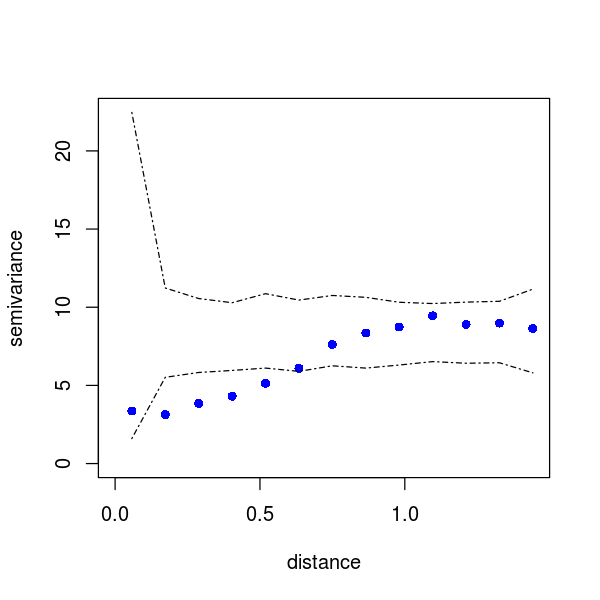

In [22]:
plot(vg, envelope=vg_envel, pch=16, col="blue")